In [1]:
import findspark

findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[1]")\
        .appName("Spark_HD_Analysis.com")\
        .getOrCreate()

In [3]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [4]:
from pyspark.ml.classification import LogisticRegression

data = spark.read.format("csv").load("Datasets/Heart_Disease_Prediction.csv", header=True, inferSchema= True)

data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Chest pain type: integer (nullable = true)
 |-- BP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FBS over 120: integer (nullable = true)
 |-- EKG results: integer (nullable = true)
 |-- Max HR: integer (nullable = true)
 |-- Exercise angina: integer (nullable = true)
 |-- ST depression: double (nullable = true)
 |-- Slope of ST: integer (nullable = true)
 |-- Number of vessels fluro: integer (nullable = true)
 |-- Thallium: integer (nullable = true)
 |-- Heart Disease: string (nullable = true)



In [5]:
data.select("Max HR").agg({"Max HR" : "avg"}).show()

+------------------+
|       avg(Max HR)|
+------------------+
|149.67777777777778|
+------------------+



In [6]:
data.groupby("Heart Disease").agg({"Max HR" : "avg"}).show()

+-------------+------------------+
|Heart Disease|       avg(Max HR)|
+-------------+------------------+
|     Presence|138.85833333333332|
|      Absence|158.33333333333334|
+-------------+------------------+



In [7]:
data.groupby("Heart Disease").agg({"BP" : "avg"}).show()

+-------------+------------------+
|Heart Disease|           avg(BP)|
+-------------+------------------+
|     Presence|134.44166666666666|
|      Absence|128.86666666666667|
+-------------+------------------+



In [8]:
data.groupby("Heart Disease").agg({"Cholesterol" : "avg"}).show()

+-------------+------------------+
|Heart Disease|  avg(Cholesterol)|
+-------------+------------------+
|     Presence|256.46666666666664|
|      Absence|244.21333333333334|
+-------------+------------------+



In [9]:
numerical_features_labels = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

In [10]:
from pyspark.ml.feature import VectorAssembler

numerical_vector_assembler = VectorAssembler(inputCols=numerical_features_labels,
                                            outputCol="numerical_features_vector")

data = numerical_vector_assembler.transform(data)

In [11]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="numerical_features_vector",
                       outputCol="scaled_numerical_feature_vector",
                       withStd=True,
                       withMean=True)

scaler = scaler.fit(data)
data = scaler.transform(data)

In [12]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Heart Disease",
                       outputCol="heart_disease_index")

indexer = indexer.fit(data)
data = indexer.transform(data)

In [13]:
categorical_features_labels = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina',\
                               'Slope of ST', 'Number of vessels fluro', 'Thallium']

In [14]:
categorical_features_onehot = ['sex_onehot', 'chest_pain_onehot', 'fbs_over_onehot', 'ekg_onehot', 'angina_onehot',\
                               'st_slope_onehot', 'fluro_onehot', 'thallium_onehot']

In [15]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCols=categorical_features_labels,
                       outputCols=categorical_features_onehot)

encoder = encoder.fit(data)
data = encoder.transform(data)

In [16]:
assembler = VectorAssembler(inputCols=["scaled_numerical_feature_vector"] + categorical_features_onehot,
                           outputCol="final_features_vector")

data = assembler.transform(data)

In [17]:
df = data.select('final_features_vector', 'heart_disease_index')
df = df.withColumnRenamed('final_features_vector', 'features')
df = df.withColumnRenamed('heart_disease_index', 'label')

df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(27,[0,1,2,3,4,10...|  1.0|
|(27,[0,1,2,3,4,5,...|  0.0|
|(27,[0,1,2,3,4,8,...|  1.0|
|(27,[0,1,2,3,4,10...|  0.0|
|(27,[0,1,2,3,4,5,...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [18]:
train, test = df.randomSplit([0.6, 0.4], seed=42)

# Classification

In [22]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from pyspark.ml.classification import LogisticRegression

log_r = LogisticRegression()

log_r = log_r.fit(train)
prediction_df = log_r.transform(test)

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

mce = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedPrecision')
precision = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedRecall')
recall = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='f1')
f1 = mce.evaluate(prediction_df)


s = '''
Accuracy:    {0}
Precision:   {1}
Recall:      {2}
F1:          {3}

'''.format(accuracy,
           precision,
           recall,
           f1)

print(s)


Accuracy:    0.819047619047619
Precision:   0.8182134440579061
Recall:      0.819047619047619
F1:          0.818552875695733




Normalized confusion matrix
[[0.86363636 0.13636364]
 [0.25641026 0.74358974]]


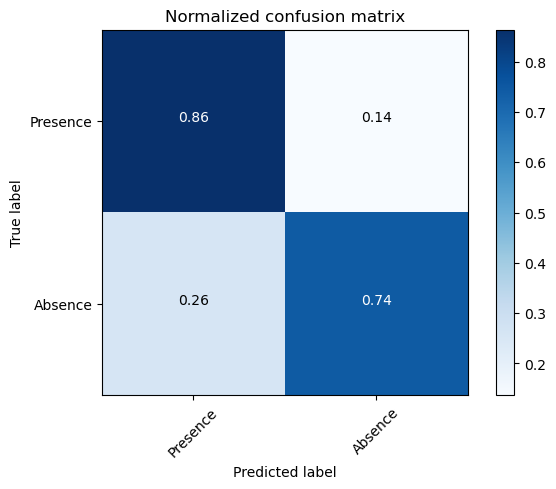

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test.select('label').toPandas()
y_pred = prediction_df.select('prediction').toPandas()
labels = ['Presence', 'Absence']

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [21]:
from pyspark.ml.classification import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

dtc = dtc.fit(train)
prediction_df = dtc.transform(test)

In [22]:
mce = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedPrecision')
precision = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedRecall')
recall = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='f1')
f1 = mce.evaluate(prediction_df)


s = '''
Accuracy:    {0}
Precision:   {1}
Recall:      {2}
F1:          {3}

'''.format(accuracy,
           precision,
           recall,
           f1)

print(s)


Accuracy:    0.7619047619047619
Precision:   0.7589717046238785
Recall:      0.761904761904762
F1:          0.7597883597883598




Normalized confusion matrix
[[0.83333333 0.16666667]
 [0.35897436 0.64102564]]


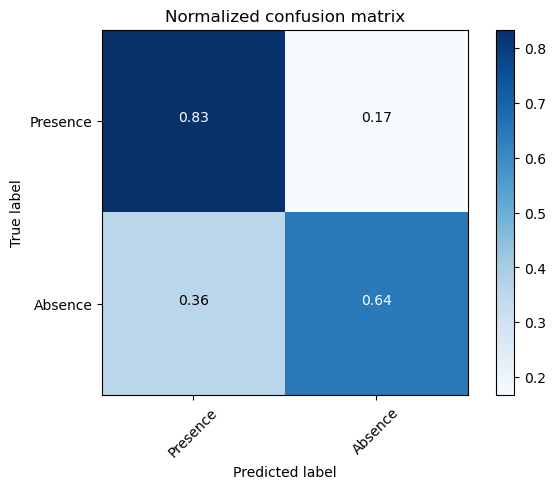

In [23]:
y_pred = prediction_df.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [24]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier()

gbt = gbt.fit(train)
prediction_df = gbt.transform(test)

In [25]:
mce = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedPrecision')
precision = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedRecall')
recall = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='f1')
f1 = mce.evaluate(prediction_df)


s = '''
Accuracy:    {0}
Precision:   {1}
Recall:      {2}
F1:          {3}

'''.format(accuracy,
           precision,
           recall,
           f1)

print(s)


Accuracy:    0.7523809523809524
Precision:   0.7501249148307971
Recall:      0.7523809523809524
F1:          0.7509707103579846




Normalized confusion matrix
[[0.81818182 0.18181818]
 [0.35897436 0.64102564]]


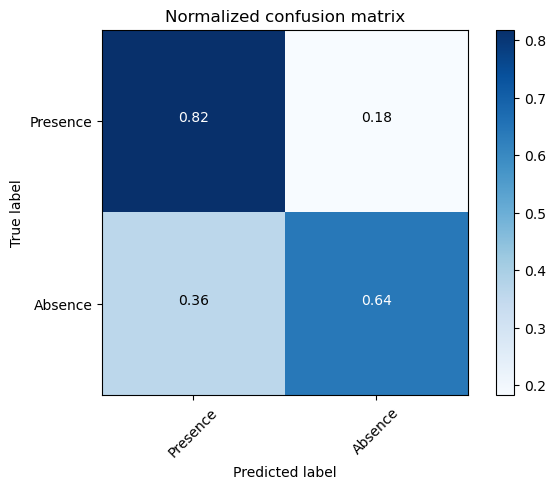

In [26]:
y_pred = prediction_df.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [27]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier()

rfc = rfc.fit(train)
prediction_df = rfc.transform(test)

In [28]:
mce = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedPrecision')
precision = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='weightedRecall')
recall = mce.evaluate(prediction_df)

mce = MulticlassClassificationEvaluator(metricName='f1')
f1 = mce.evaluate(prediction_df)


s = '''
Accuracy:    {0}
Precision:   {1}
Recall:      {2}
F1:          {3}

'''.format(accuracy,
           precision,
           recall,
           f1)

print(s)


Accuracy:    0.819047619047619
Precision:   0.8201098901098901
Recall:      0.819047619047619
F1:          0.8195022293389287




Normalized confusion matrix
[[0.84848485 0.15151515]
 [0.23076923 0.76923077]]


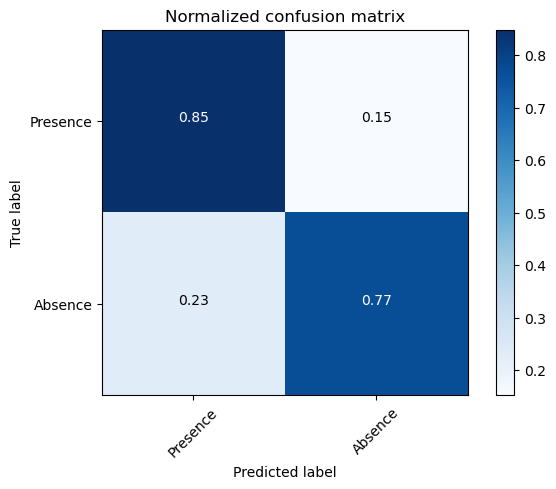

In [29]:
y_pred = prediction_df.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

# Regression

In [30]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()

lr = lr.fit(train)
prediction_df = lr.transform(test)

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

eva = RegressionEvaluator()
rmse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mse')
mse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='r2')
r2 = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mae')
mae = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='var')
var = eva.evaluate(prediction_df)

s = '''
RMSE:  {0}
MSE:   {1}
R**2:  {2}
MAE:   {3}
VAR:   {4}

'''.format(rmse,
           mse,
           r2,
           mae,
           var)

print(s)


RMSE:  0.36775240507438933
MSE:   0.13524183143799773
R**2:  0.42072991779179303
MAE:   0.2886099962542401
VAR:   0.13246198205877455




In [32]:
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

dtr = dtr.fit(train)
prediction_df = dtr.transform(test)

In [33]:
eva = RegressionEvaluator()
rmse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mse')
mse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='r2')
r2 = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mae')
mae = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='var')
var = eva.evaluate(prediction_df)

s = '''
RMSE:  {0}
MSE:   {1}
R**2:  {2}
MAE:   {3}
VAR:   {4}

'''.format(rmse,
           mse,
           r2,
           mae,
           var)

print(s)


RMSE:  0.47955556933597465
MSE:   0.2299735440811508
R**2:  0.014973456295770182
MAE:   0.26641929499072353
VAR:   0.19946625545141305




In [34]:
from pyspark.ml.regression import GBTRegressor

gbtr = GBTRegressor()

gbtr = gbtr.fit(train)
prediction_df = gbtr.transform(test)

In [35]:
eva = RegressionEvaluator()
rmse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mse')
mse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='r2')
r2 = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mae')
mae = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='var')
var = eva.evaluate(prediction_df)

s = '''
RMSE:  {0}
MSE:   {1}
R**2:  {2}
MAE:   {3}
VAR:   {4}

'''.format(rmse,
           mse,
           r2,
           mae,
           var)

print(s)


RMSE:  0.498388505035309
MSE:   0.24839110195133024
R**2:  -0.0639129366796487
MAE:   0.2936230497421961
VAR:   0.21749866476343946




In [36]:
from pyspark.ml.regression import RandomForestRegressor

rfr = RandomForestRegressor()

rfr = rfr.fit(train)
prediction_df = rfr.transform(test)

In [37]:
eva = RegressionEvaluator()
rmse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mse')
mse = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='r2')
r2 = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='mae')
mae = eva.evaluate(prediction_df)

eva = RegressionEvaluator(metricName='var')
var = eva.evaluate(prediction_df)

s = '''
RMSE:  {0}
MSE:   {1}
R**2:  {2}
MAE:   {3}
VAR:   {4}

'''.format(rmse,
           mse,
           r2,
           mae,
           var)

print(s)


RMSE:  0.3563511664543567
MSE:   0.12698615383338063
R**2:  0.4560907746647159
MAE:   0.27770399502617493
VAR:   0.09989051368853065




# Clustering

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

ceva = ClusteringEvaluator()
silhouette_scores = []
inertia_scores = []

for k_ in range(2, 11):
    km = KMeans(k=k_)
    km = km.fit(train)
    prediction_df = km.transform(test)
    silhouette_scores.append(ceva.evaluate(prediction_df))
    inertia_scores.append(km.summary.trainingCost)

Text(0, 0.5, 'Inertia')

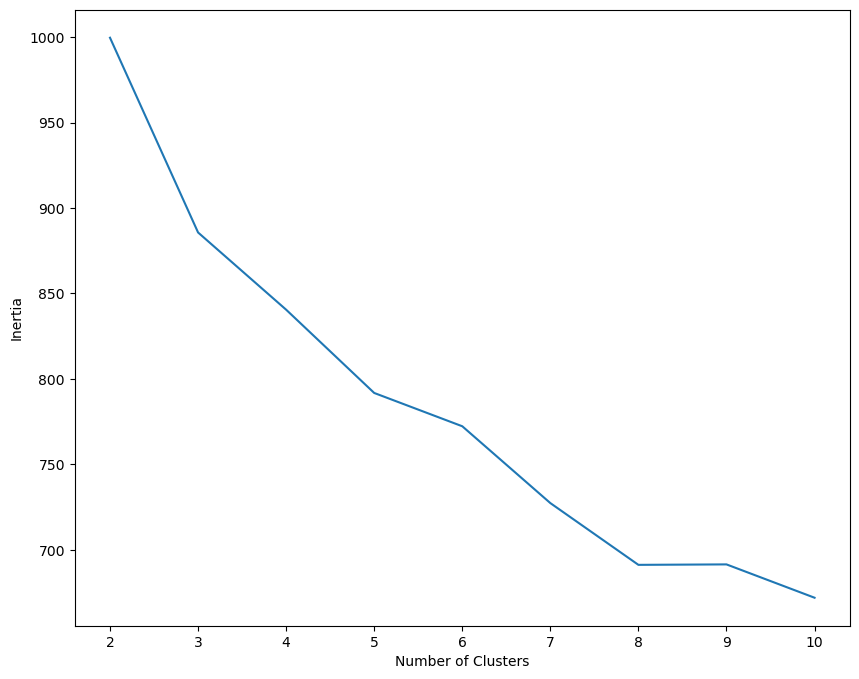

In [23]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),inertia_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')

In [24]:
silhouette_scores[1]

0.26161389911396554

In [28]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.functions import vector_to_array

km = KMeans(k=3)
km = km.fit(df)
prediction_df = km.transform(df)

pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(df)
pca_transformed = pca_model.transform(df)
pca_transformed = pca_transformed.withColumn('pca', vector_to_array('pca'))

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(prediction_df.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

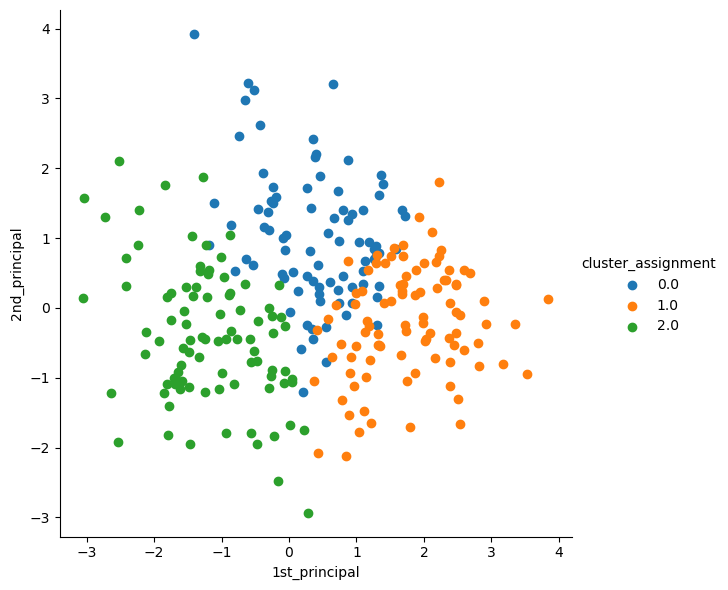

In [29]:
import seaborn as sns
import pandas as pd

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df, hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [42]:
from pyspark.ml.clustering import GaussianMixture

gm = GaussianMixture()

gm = gm.fit(train)
prediction_df = gm.transform(test)

ceva = ClusteringEvaluator()
print(f"Silhouette: {ceva.evaluate(prediction_df)}")

Silhouette: 0.03918439112527597


In [43]:
gm = GaussianMixture()
gm = gm.fit(df)
prediction_df = gm.transform(df)

pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(df)
pca_transformed = pca_model.transform(df)
pca_transformed = pca_transformed.withColumn('pca', vector_to_array('pca'))

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(prediction_df.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

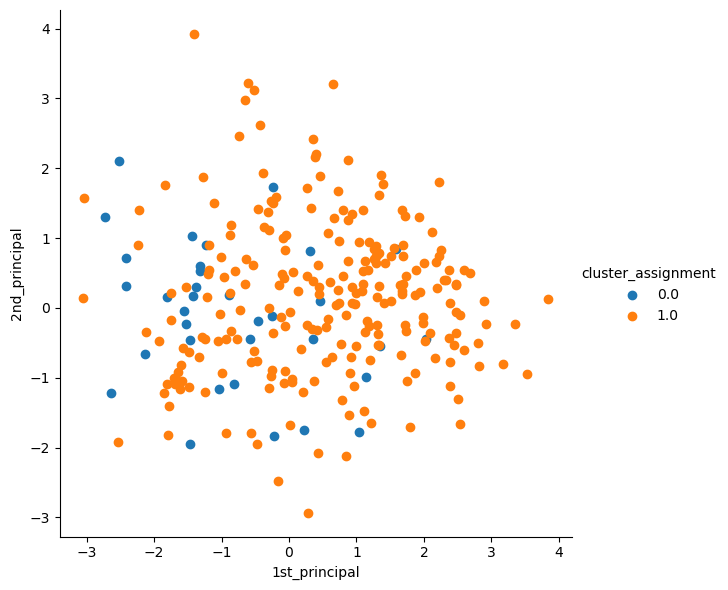

In [44]:
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df, hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [25]:
from pyspark.ml.clustering import BisectingKMeans

ceva = ClusteringEvaluator()
silhouette_scores = []
inertia_scores = []

for k_ in range(2, 11):
    bkm = BisectingKMeans(k=k_)
    bkm = bkm.fit(train)
    prediction_df = bkm.transform(test)
    silhouette_scores.append(ceva.evaluate(prediction_df))
    inertia_scores.append(bkm.summary.trainingCost)

Text(0, 0.5, 'Inertia')

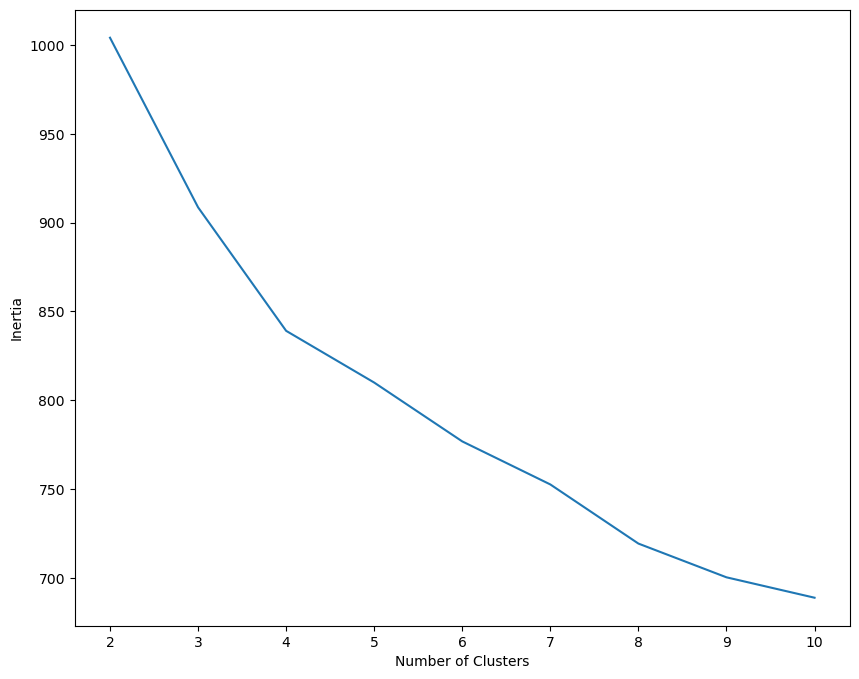

In [26]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),inertia_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')

In [32]:
silhouette_scores[1]

0.15974589881083837

In [35]:
bkm = BisectingKMeans(k=3)
bkm = bkm.fit(df)
prediction_df = bkm.transform(df)

pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(df)
pca_transformed = pca_model.transform(df)
pca_transformed = pca_transformed.withColumn('pca', vector_to_array('pca'))

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(prediction_df.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

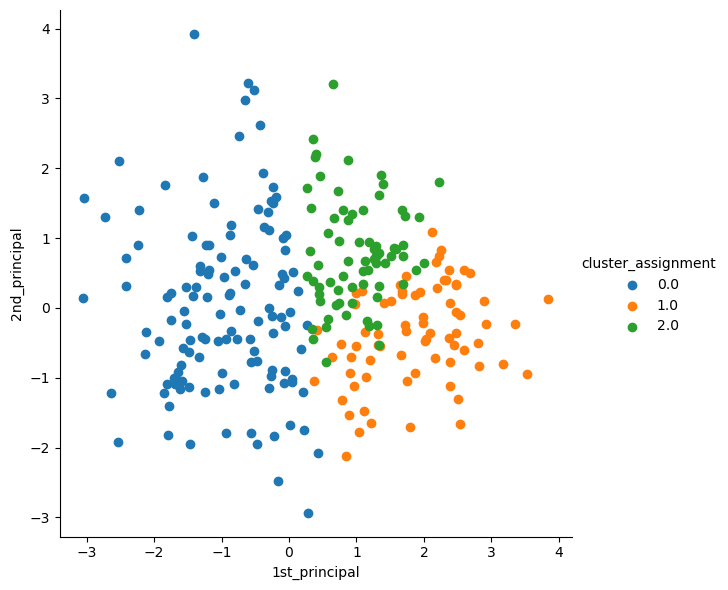

In [36]:
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df, hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()